In [2]:

import glob
import time

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from keras import Input
from keras.applications.vgg19 import VGG19
from keras.callbacks import TensorBoard
from keras.layers import BatchNormalization, Activation, LeakyReLU, Add, Dense
from keras.layers.convolutional import Conv2D, UpSampling2D
from keras.models import Model
from keras.optimizers import Adam


import pandas as pd
import numpy as np
from keras.models import load_model
import tensorflow as tf
import os
from tqdm import tqdm
from glob import glob
import gc
import cv2
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import math
import zipfile
from keras.layers import Dense
from keras.layers.core import Activation
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import UpSampling2D
from keras.layers.core import Flatten
from keras.layers import Input
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.models import Model
from keras.layers.advanced_activations import LeakyReLU, PReLU
from keras.layers import add
from keras.applications.vgg19 import VGG19
from keras.preprocessing import image
import keras.backend as K
from keras.models import Model
from keras.optimizers import Adam
import pandas as pd
import numpy as np
import os
import cv2
from tqdm.auto import tqdm
import concurrent.futures
import functools
from google.colab import files



In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
train_csv = pd.read_csv('/content/drive/MyDrive/train.csv')
test_csv = pd.read_csv('/content/drive/MyDrive/test.csv')
train_csv.head(),test_csv.head()
BATCH_SIZE = 8
img_size = 256
#weights = None
weights = 'imagenet'
learning_rate = 1e-5
EPOCHS = 5
dropout_rate = 0.1

In [5]:
train_all_input_files = '/content/drive/MyDrive/train_input_img/'+train_csv['input_img']
train_all_label_files = '/content/drive/MyDrive/train_label_img/'+train_csv['label_img']
test_all_input_files = '/content/drive/MyDrive/LG_data_test/images/test/'+test_csv['input_img']

In [6]:
train_all_input_files.head(),train_all_label_files.head()

(0    /content/drive/MyDrive/train_input_img/train_i...
 1    /content/drive/MyDrive/train_input_img/train_i...
 2    /content/drive/MyDrive/train_input_img/train_i...
 3    /content/drive/MyDrive/train_input_img/train_i...
 4    /content/drive/MyDrive/train_input_img/train_i...
 Name: input_img, dtype: object,
 0    /content/drive/MyDrive/train_label_img/train_l...
 1    /content/drive/MyDrive/train_label_img/train_l...
 2    /content/drive/MyDrive/train_label_img/train_l...
 3    /content/drive/MyDrive/train_label_img/train_l...
 4    /content/drive/MyDrive/train_label_img/train_l...
 Name: label_img, dtype: object)

In [7]:
#train_inp_files = glob(f'/content/drive/MyDrive/LG_train_save_file/train256/train_input_img_{img_size}/*.png')
#train_targ_files = glob(f'/content/drive/MyDrive/LG_train_save_file/label256/train_label_img_{img_size}/*.png')



In [8]:
#train_inp_files, train_targ_files = shuffle(train_inp_files, train_targ_files, random_state=42)

In [9]:
#len(train_inp_files)

In [10]:

def load_dataset(train_all_input_files,train_all_label_files,a,b):
    final_train_input=[]
    final_label_input=[]
    for index in range(a,b):
        
        train_path=train_all_input_files[index]
        '''
        train_input=cv2.imread(train_path)
        train_input=cv2.resize(train_input,(256,256),)
        train_input = cv2.cvtColor(train_input, cv2.COLOR_BGR2RGB)
        train_input=train_input.astype(np.float32)
        '''
        train_input=image.load_img(train_path,target_size=(256,256))
        train_input=image.img_to_array(train_input)
        train_input=np.array(train_input,dtype=np.float32)


        # -1~1로 변환
        
        
        label_path=train_all_label_files[index]
        label_input=image.load_img(label_path,target_size=(256,256))
        label_input=image.img_to_array(label_input)
        label_input=np.array(label_input,dtype=np.float32)
       
        #label_input=label_input/127.5-1  #-1~1로 변환
        
        
        final_train_input.append(train_input)
        final_label_input.append(label_input)
        
        #train_input 저해상도 label_input 고해상도
    return final_train_input,final_label_input

def load_testset(test_all_input_files):
    test_data=[]
    for index in range(len(test_all_input_files)):
        test_path=test_all_input_files[index]
        test_input=image.load_img(test_path,target_size=(256,256))
        test_input=image.img_to_array(test_input)
        test_input=np.array(test_input,dtype=np.float32)
        
        
        #test_input=test_input/127.5-1 #normalization을 해준다
        test_data.append(test_input)
    return test_data


final_train_input,final_label_input=load_dataset(train_all_input_files,train_all_label_files,0,622)
       
        
test_input=load_testset(test_all_input_files)
        
       

        
        


len(final_train_input),len(final_label_input),len(test_input)


(622, 622, 20)

In [11]:
weights = 'imagenet'
final_train_input=np.array(final_train_input)
final_train_input=final_train_input.reshape(-1,256,256,3)
final_label_input=np.array(final_label_input)
final_label_input=final_label_input.reshape(-1,256,256,3)
final_label_input.shape

(622, 256, 256, 3)

'\nclass SRValidator:\n  def __init__(self):\n        self.upscale_factor = 4\n        self.model = self.build((256,256,3))\n  \n  def disc_block(self, input, n_filters, batch_norm):\n    x = Conv2D(filters = n_filters, kernel_size = 3, padding = \'same\')(input)\n    if batch_norm:\n        x = BatchNormalization(momentum=0.8)(x)\n    x = LeakyReLU(alpha=0.2)(x)\n    x = Conv2D(filters = n_filters, kernel_size = 3,\n                strides=2, padding = \'same\')(x)\n    x = BatchNormalization(momentum=0.8)(x)\n    x = LeakyReLU(alpha=0.2)(x)\n    return x\n\n  def build(self, input_shape, blocks_num=4):\n    inputs = keras.Input(shape=input_shape)\n    x = inputs\n    for i in range(blocks_num):\n      x = self.disc_block(x, (2 ** i) * 64, False if i == 0 else True)\n    x = Flatten()(x)\n    x = Dense(1024)(x)\n    x = LeakyReLU(alpha=0.2)(x)\n    outputs = Dense(1, activation=\'sigmoid\')(x)\n    model = Model(inputs=inputs, outputs=outputs, name="SRValidator")\n    model.compile(\n

In [ ]:

class Generator():
    def __init__(self,input_shape):
        self.input_shape=input_shape

    def residual_block(x):
    
        filters = [64, 64]
        kernel_size = 3
        strides = 1
        padding = "same"
        momentum = 0.8
        activation = "relu"

        res = Conv2D(filters=filters[0], kernel_size=kernel_size, strides=strides, padding=padding)(x)
        res = Activation(activation=activation)(res)
        res = BatchNormalization(momentum=momentum)(res)

        res = Conv2D(filters=filters[1], kernel_size=kernel_size, strides=strides, padding=padding)(res)
        res = BatchNormalization(momentum=momentum)(res)

        
        res = Add()([res, x])
        return res

    def build_generator(self):

        residual_blocks = 16
        momentum = 0.8
        

        
        input_layer = Input(shape=self.input_shape)

        
        gen1 = Conv2D(filters=64, kernel_size=9, strides=2, padding='same')(input_layer)
        
        
        res = residual_block(gen1)
        for i in range(residual_blocks - 1):
            res = residual_block(res)

        
        gen2 = Conv2D(filters=64, kernel_size=3, strides=1, padding='same')(res)
        gen2 = BatchNormalization(momentum=momentum)(gen2)

        
        gen3 = Add()([gen2, gen1])

        
        gen4 = UpSampling2D(size=2)(gen3)
        gen4 = Conv2D(filters=256, kernel_size=3, strides=2, padding='same')(gen4)
        gen4 = LeakyReLU(0.1)(gen4)

        gen4 = Conv2D(filters=256, kernel_size=3, strides=1, padding='same')(gen4)
        gen4 = LeakyReLU(0.1)(gen4)

        gen4 = Conv2D(filters=256, kernel_size=3, strides=1, padding='same')(gen4)
        gen4 = LeakyReLU(0.1)(gen4)

        
        gen5 = UpSampling2D(size=2)(gen4)
        gen5 = Conv2D(filters=256, kernel_size=3, strides=1, padding='same')(gen5)
        gen5 = Activation('relu')(gen5)

        
        gen6 = Conv2D(filters=3, kernel_size=9, strides=1, padding='same')(gen5)
        output = Activation('tanh')(gen6)

        
        model = Model(inputs=[input_layer], outputs=[output], name='generator')
        return model

def build_generator():
    def residual_block(x):
    
        filters = (64,64)
        kernel_size = 3
        strides = 1
        padding = "same"
        momentum = 0.8
        activation = "relu"

        res = Conv2D(filters=filters[0], kernel_size=kernel_size, strides=strides, padding=padding)(x)
        res = Activation(activation=activation)(res)
        res = BatchNormalization(momentum=momentum)(res)

        res = Conv2D(filters=filters[1], kernel_size=kernel_size, strides=strides, padding=padding)(res)
        res = BatchNormalization(momentum=momentum)(res)

        
        res = Add()([res, x])
        return res
    residual_blocks = 16
    momentum = 0.8
    input_shape=(None,None,3)

    
    input_layer = Input(shape=input_shape)

    
    gen1 = Conv2D(filters=64, kernel_size=9, strides=2, padding='same')(input_layer)
    
    
    res = residual_block(gen1)
    for i in range(residual_blocks - 1):
        res = residual_block(res)

    
    gen2 = Conv2D(filters=64, kernel_size=3, strides=1, padding='same')(res)
    gen2 = BatchNormalization(momentum=momentum)(gen2)

    
    gen3 = Add()([gen2, gen1])

    
    gen4 = UpSampling2D(size=2)(gen3)
    gen4 = Conv2D(filters=256, kernel_size=3, strides=2, padding='same')(gen4)
    gen4 = LeakyReLU(0.1)(gen4)

    gen4 = Conv2D(filters=256, kernel_size=3, strides=1, padding='same')(gen4)
    gen4 = LeakyReLU(0.1)(gen4)

    gen4 = Conv2D(filters=256, kernel_size=3, strides=1, padding='same')(gen4)
    gen4 = LeakyReLU(0.1)(gen4)

    
    gen5 = UpSampling2D(size=2)(gen4)
    gen5 = Conv2D(filters=256, kernel_size=3, strides=1, padding='same')(gen5)
    gen5 = Activation('relu')(gen5)

    
    gen6 = Conv2D(filters=3, kernel_size=9, strides=1, padding='same')(gen5)
    output = Activation('tanh')(gen6)

    
    model = Model(inputs=[input_layer], outputs=[output], name='generator')
    return model



'''
class Discriminator():
    def __init__(self,input_shape):
        self.input_shape=input_shape

    def build_discriminator(self):

        leakyrelu_alpha = 0.2
        momentum = 0.8
        

        input_layer = Input(shape=self.input_shape)

        
        dis1 = Conv2D(filters=64, kernel_size=3, strides=1, padding='same')(input_layer)
        dis1 = LeakyReLU(alpha=leakyrelu_alpha)(dis1)

        
        dis2 = Conv2D(filters=64, kernel_size=3, strides=1, padding='same')(dis1)
        dis2 = LeakyReLU(alpha=leakyrelu_alpha)(dis2)
        dis2 = BatchNormalization(momentum=momentum)(dis2)

        
        dis3 = Conv2D(filters=128, kernel_size=3, strides=1, padding='same')(dis2)
        dis3 = LeakyReLU(alpha=leakyrelu_alpha)(dis3)
        dis3 = BatchNormalization(momentum=momentum)(dis3)

        
        dis4 = Conv2D(filters=128, kernel_size=3, strides=1, padding='same')(dis3)
        dis4 = LeakyReLU(alpha=leakyrelu_alpha)(dis4)
        dis4 = BatchNormalization(momentum=0.8)(dis4)

        
        dis5 = Conv2D(256, kernel_size=3, strides=1, padding='same')(dis4)
        dis5 = LeakyReLU(alpha=leakyrelu_alpha)(dis5)
        dis5 = BatchNormalization(momentum=momentum)(dis5)

        
        dis6 = Conv2D(filters=256, kernel_size=3, strides=1, padding='same')(dis5)
        dis6 = LeakyReLU(alpha=leakyrelu_alpha)(dis6)
        dis6 = BatchNormalization(momentum=momentum)(dis6)

        
        dis7 = Conv2D(filters=512, kernel_size=3, strides=1, padding='same')(dis6)
        dis7 = LeakyReLU(alpha=leakyrelu_alpha)(dis7)
        dis7 = BatchNormalization(momentum=momentum)(dis7)

        
        dis8 = Conv2D(filters=512, kernel_size=3, strides=1, padding='same')(dis7)
        dis8 = LeakyReLU(alpha=leakyrelu_alpha)(dis8)
        dis8 = BatchNormalization(momentum=momentum)(dis8)

        
        dis9 = Dense(units=1024)(dis8)
        dis9 = LeakyReLU(alpha=0.2)(dis9)

        
        output = Dense(units=1, activation='sigmoid')(dis9)

        model = Model(inputs=[input_layer], outputs=[output], name='discriminator')
        
        return model

'''
def build_discriminator():

    leakyrelu_alpha = 0.2
    momentum = 0.8
    
    input_shape=(None,None,3)
    input_layer = Input(shape=input_shape)

    
    dis1 = Conv2D(filters=64, kernel_size=3, strides=1, padding='same')(input_layer)
    dis1 = LeakyReLU(alpha=leakyrelu_alpha)(dis1)

    
    dis2 = Conv2D(filters=64, kernel_size=3, strides=1, padding='same')(dis1)
    dis2 = LeakyReLU(alpha=leakyrelu_alpha)(dis2)
    dis2 = BatchNormalization(momentum=momentum)(dis2)

    
    dis3 = Conv2D(filters=128, kernel_size=3, strides=1, padding='same')(dis2)
    dis3 = LeakyReLU(alpha=leakyrelu_alpha)(dis3)
    dis3 = BatchNormalization(momentum=momentum)(dis3)

    
    dis4 = Conv2D(filters=128, kernel_size=3, strides=1, padding='same')(dis3)
    dis4 = LeakyReLU(alpha=leakyrelu_alpha)(dis4)
    dis4 = BatchNormalization(momentum=0.8)(dis4)

    
    dis5 = Conv2D(256, kernel_size=3, strides=1, padding='same')(dis4)
    dis5 = LeakyReLU(alpha=leakyrelu_alpha)(dis5)
    dis5 = BatchNormalization(momentum=momentum)(dis5)

    
    dis6 = Conv2D(filters=256, kernel_size=3, strides=1, padding='same')(dis5)
    dis6 = LeakyReLU(alpha=leakyrelu_alpha)(dis6)
    dis6 = BatchNormalization(momentum=momentum)(dis6)

    
    dis7 = Conv2D(filters=512, kernel_size=3, strides=1, padding='same')(dis6)
    dis7 = LeakyReLU(alpha=leakyrelu_alpha)(dis7)
    dis7 = BatchNormalization(momentum=momentum)(dis7)

    
    dis8 = Conv2D(filters=512, kernel_size=3, strides=1, padding='same')(dis7)
    dis8 = LeakyReLU(alpha=leakyrelu_alpha)(dis8)
    dis8 = BatchNormalization(momentum=momentum)(dis8)

    
    dis9 = Dense(units=1024)(dis8)
    dis9 = LeakyReLU(alpha=0.2)(dis9)

    
    output = Dense(units=1, activation='sigmoid')(dis9)

    model = Model(inputs=[input_layer], outputs=[output], name='discriminator')
    
    return model

In [ ]:
def build_vgg():
    """
    Build VGG network to extract image features
    """
    input_shape = (None, None, 3)

    # 사전학습된 모델인 vgg 를 가져온다 저는 vgg 사용하다가 ResNet 으로변경함
    vgg =tf.keras.applications.ResNet152V2(weights="imagenet",include_top=False, input_shape=(256, 256, 3))
    
    
    
    
    
    
    
    ## 모델생성~
    model = Model(inputs=vgg.inputs, outputs=vgg.layers[9].output)
    model.compile(loss='mse', optimizer=common_optimizer, metrics=['accuracy'])
    
    return model


def sample_images(batch_size, high_resolution_shape, low_resolution_shape):
    #폴더에있는 모든이미지리스트를만듬
    

    low_resolution_images = []
    high_resolution_images = []
    
    id=np.random.randint(0,622,batch_size)
    
    for index in id:
        # Get an ndarray of the current image
        low=final_train_input[index] #low에는 float32 type ndarray가들어가있음 
        
        high=final_label_input[index]#high 에는 float32 type ndarray가들어가있음
        # Resize the image
        

        # Do a random horizontal flip
        if np.random.random() < 0.5:
            high = np.fliplr(high)
            low= np.fliplr(low)

        high_resolution_images.append(high)
        low_resolution_images.append(low)

    # Convert the lists to Numpy NDArrays
    return np.array(high_resolution_images), np.array(low_resolution_images)


def save_images(low_resolution_image, original_image, generated_image, path):
   
    fig = plt.figure()
    ax = fig.add_subplot(1, 3, 1)
    ax.imshow(low_resolution_image)
    ax.axis("off")
    ax.set_title("low-resolution")

    ax = fig.add_subplot(1, 3, 2)
    ax.imshow(original_image)
    ax.axis("off")
    ax.set_title("original")

    ax = fig.add_subplot(1, 3, 3)
    ax.imshow(generated_image)
    ax.axis("off")
    ax.set_title("generated")

    plt.savefig(path)
'''
def write_log(callback, name, value, batch_no):
    
    summary = tf.Summary()
    summary_value = summary.value.add()
    summary_value.simple_value = value
    summary_value.tag = name
    callback.writer.add_summary(summary, batch_no)
    callback.writer.flush()
'''


In [ ]:
def rmse_score(true, pred):
    score = math.sqrt(np.mean((true-pred)**2))
    return score

def psnr_score(true, pred, pixel_max):
    score = 20*np.log10(pixel_max/rmse_score(true, pred))
    return score
def visualize_image(img):
   display(image.array_to_img(img))

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Total params: 14,080
Trainable params: 13,824
Non-trainable params: 256
_________________________________________________________________
Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
conv2d_56 (Conv2D)           (None, None, None, 64)    1792      
_________________________________________________________________
leaky_re_lu_21 (LeakyReLU)   (None, None, None, 64)    0         
_________________________________________________________________
conv2d_57 (Conv2D)           (None, None, None, 64)    36928     
_________________________________________________________________
leaky_re_lu_22 (LeakyReLU)   (

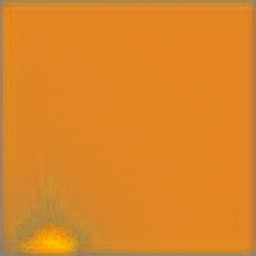

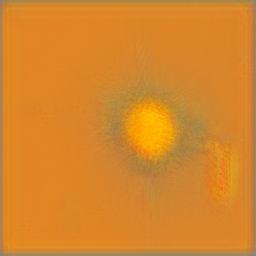

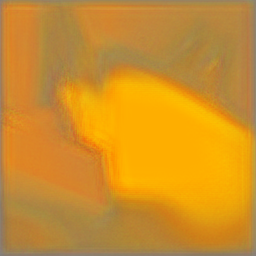

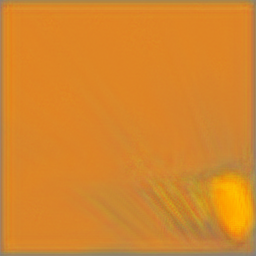

Epoch:1
d_loss: [0.30010845 0.49392509]
g_loss: [0.9847301244735718, 1.0087659358978271, 0.9837213754653931]
Epoch:2
d_loss: [0.29839697 0.55207825]
g_loss: [1.1245832443237305, 1.2299834489822388, 1.1233532428741455]
Epoch:3
d_loss: [0.22904489 0.64160538]
g_loss: [0.7929807305335999, 1.567185640335083, 0.7914135456085205]
Epoch:4
d_loss: [0.09975262 0.93201447]
g_loss: [0.6765695810317993, 2.3716530799865723, 0.6741979122161865]
Epoch:5
d_loss: [0.07379709 0.91795921]
g_loss: [0.5751122832298279, 2.7225193977355957, 0.5723897814750671]
Epoch:6
d_loss: [0.06709644 0.92494011]
g_loss: [0.5445123314857483, 2.4383440017700195, 0.5420739650726318]
Epoch:7
d_loss: [0.08513617 0.89904976]
g_loss: [0.576750636100769, 2.4210400581359863, 0.5743296146392822]
Epoch:8
d_loss: [0.30163567 0.52783012]
g_loss: [0.42399996519088745, 3.1601860523223877, 0.420839786529541]
Epoch:9
d_loss: [0.5132449  0.27420616]
g_loss: [0.4607490599155426, 2.3867616653442383, 0.45836231112480164]
Epoch:10
d_loss: [0.

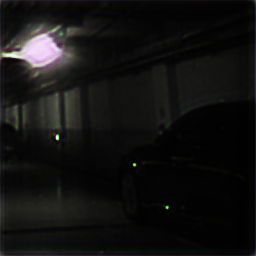

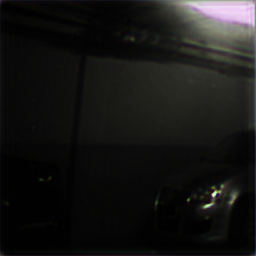

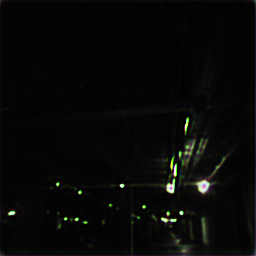

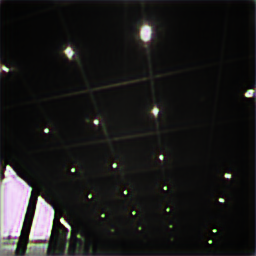

Epoch:101
d_loss: [0.1164129  0.91624641]
g_loss: [0.1268664449453354, 2.0661065578460693, 0.12480033189058304]
Epoch:102
d_loss: [0.02972417 0.9950695 ]
g_loss: [0.07046326994895935, 2.1731386184692383, 0.06829012930393219]
Epoch:103
d_loss: [0.01602418 0.99721146]
g_loss: [0.07808399945497513, 2.170658588409424, 0.07591333985328674]
Epoch:104
d_loss: [0.01420197 0.99798584]
g_loss: [0.12019715458154678, 2.5458850860595703, 0.11765126883983612]
Epoch:105
d_loss: [0.01364795 0.99865341]
g_loss: [0.12920385599136353, 2.132408618927002, 0.12707144021987915]
Epoch:106
d_loss: [0.03422277 0.99564171]
g_loss: [0.11132173240184784, 2.250117778778076, 0.10907161235809326]
Epoch:107
d_loss: [0.01881718 0.99898911]
g_loss: [0.1916184425354004, 2.482147693634033, 0.1891362965106964]
Epoch:108
d_loss: [0.05884753 0.98977089]
g_loss: [0.09258878231048584, 2.4886884689331055, 0.09010009467601776]
Epoch:109
d_loss: [0.08059888 0.95086098]
g_loss: [0.08558937162160873, 2.212475538253784, 0.0833768993

In [ ]:
import os

os.environ['TF_CPP_MIN_LOG_LEVEL']='2'
epochs = 30000
batch_size = 4


## image shape 지정한다
low_resolution_shape = (256, 256, 3)
high_resolution_shape = (256, 256, 3)

## Common optimizer for all networks
common_optimizer = Adam(0.0002, 0.5)
vgg = build_vgg()
vgg.compile(loss='mse', optimizer=common_optimizer, metrics=['accuracy'])
vgg.summary()
vgg.trainable = False


# Build and compile the discriminator network
shape=(256,256,3)
#discriminator =load_model("/content/drive/MyDrive/LG_result/720srdiscriminator5000.h5")
discriminator=build_discriminator()
discriminator.compile(loss='mse', optimizer=common_optimizer, metrics=['accuracy'])

discriminator.summary()


# Build the generator network
#generator = load_model("/content/drive/MyDrive/LG_result/720srgenerator5000.h5")
generator=build_generator()
generator.summary()



#Build and compile the adversarial model


# 저해상도,고해상도 Input layers 를 만듬
input_high_resolution = Input(shape=high_resolution_shape)
input_low_resolution = Input(shape=low_resolution_shape)

# 저해상도에서 고해상도이미지 생성
generated_high_resolution_images = generator(input_low_resolution)

# generator 가생성해낸 이미지의 특징추출 
features = vgg(generated_high_resolution_images)

# discriminator 훈련 중지
discriminator.trainable = False

## probability 저장
probs = discriminator(generated_high_resolution_images)

## adversarila 모델 생성
adversarial_model = Model([input_low_resolution, input_high_resolution], [probs, features])
adversarial_model.compile(loss=['binary_crossentropy', 'mse'], loss_weights=[1e-3, 1], optimizer=common_optimizer,)




for epoch in range(epochs):
    print("Epoch:{}".format(epoch))

    """
    Train the discriminator network
    """

    
    high_resolution_images, low_resolution_images = sample_images(batch_size=batch_size,
                                                                  low_resolution_shape=low_resolution_shape,
                                                                  high_resolution_shape=high_resolution_shape)
    high_resolution_images = high_resolution_images / 127.5 - 1.
    low_resolution_images = low_resolution_images / 127.5 - 1.

    # low resolution image 로 high resolution 을 만들어냄
    generated_high_resolution_images = generator.predict(low_resolution_images)

    # real 과 label 을 만들 크기생성 
    real_labels = np.ones((batch_size, 256, 256, 1))
    fake_labels = np.zeros((batch_size, 256, 256, 1))
    
    # discriminator 학습
    d_loss_real = discriminator.train_on_batch(high_resolution_images, real_labels)
    d_loss_fake = discriminator.train_on_batch(generated_high_resolution_images, fake_labels)

    #  discriminator 손실함수의 합
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
    print("d_loss:", d_loss)

    ## network 훈련

    ## batch_size 만큼 샘플추출한다.
    high_resolution_images, low_resolution_images = sample_images( batch_size=batch_size,
                                                                  low_resolution_shape=low_resolution_shape,
                                                                  high_resolution_shape=high_resolution_shape)
    
    high_resolution_images = high_resolution_images / 127.5 - 1.
    low_resolution_images = low_resolution_images / 127.5 - 1.

    ## vgg 를 활용한 feature map 추출
    image_features = vgg.predict(high_resolution_images)
    

    ## generator network 훈련
    g_loss = adversarial_model.train_on_batch([low_resolution_images, high_resolution_images],
                                     [real_labels, image_features])

    print("g_loss:", g_loss)

    
    
    generated_images = generator.predict_on_batch(low_resolution_images)
           
    # epoch 마다 저장을 해놓아야함 아래수치마다 저장함
    if epoch % 100 == 0:
        
        # Normalize images
        high_resolution_images, low_resolution_images = sample_images(batch_size=batch_size,
                                                                low_resolution_shape=low_resolution_shape,
                                                                high_resolution_shape=high_resolution_shape)
                # Normalize images
        high_resolution_images = high_resolution_images / 127.5 - 1.
        low_resolution_images = low_resolution_images / 127.5 - 1.

        generated_images = generator.predict_on_batch(low_resolution_images)

        for index, img in enumerate(generated_images):
            visualize_image(img)
        
        
    if epoch%1000==0 and epoch!=0:
        

        for index, img in enumerate(generated_images):
            save_images(low_resolution_images[index], high_resolution_images[index], img,
                        path="/content/drive/MyDrive/LG_result/img_{}_{}".format(epoch, index))
    if epoch%2500==0 and epoch!=0:
        generator.save_weights("/content/drive/MyDrive/LG_result/720srgenerator.h5")
        discriminator.save_weights("/content/drive/MyDrive/LG_result/720srdiscriminator.h5")
        generator.save(f"/content/drive/MyDrive/LG_result/720srgenerator{epoch}.h5")
        discriminator.save(f"/content/drive/MyDrive/LG_result/720srdiscriminator{epoch}.h5")


## 모델저장

generator.save_weights("/content/drive/MyDrive/LG_result/720srgenerator.h5")
discriminator.save_weights("/content/drive/MyDrive/LG_result/720srdiscriminator.h5")
generator.save(f"/content/drive/MyDrive/LG_result/720srgenerator{epochs}.h5")
discriminator.save(f"/content/drive/MyDrive/LG_result/720srdiscriminator{epochs}.h5")


In [ ]:
def rmse_score(true, pred):
    score = math.sqrt(np.mean((true-pred)**2))
    return score

def psnr_score(true, pred, pixel_max):
    score = 20*np.log10(pixel_max/rmse_score(true, pred))
    return score


In [ ]:
img_size=256
def predict(img_paths, stride=64, batch_size=2):
    results = []
    i=0
    for path in img_paths:
        img =image.load_img(path)
        
        img = image.img_to_array(img)
        img = np.array(img,dtype=np.float32)
        
        
        img = np.array(img,dtype=np.float32)/127.5-1
        
        # image size 는 2448*3264 이다
        
        crop = []
        position = []
        batch_count = 0

        result_img = np.zeros_like(img)
       
        voting_mask = np.zeros_like(img)
        
        for top in tqdm(range(0, img.shape[0], stride)):
            for left in range(0, img.shape[1], stride):
                piece = np.zeros([img_size, img_size, 3], np.float32)
                
                temp = img[top:top+img_size, left:left+img_size, :]
                
                piece[:temp.shape[0], :temp.shape[1], :] = temp
                crop.append(piece)
                
                position.append([top, left])
                batch_count += 1
                
                if batch_count == batch_size:
                    crop = np.array(crop)
                
                    pred = (generator.predict(crop))
                    
                    
                    
                    

                    crop = []
                    batch_count = 0
                    for num, (t, l) in enumerate(position):
                        piece = pred[num]
                        h, w, c = result_img[t:t+img_size, l:l+img_size, :].shape
                        result_img[t:t+img_size, l:l+img_size, :] += piece[:h, :w]
                        
                        voting_mask[t:t+img_size, l:l+img_size, :] += 1
                        
                    
                    position = []
        
        result_img = result_img/voting_mask
        result_img= image.array_to_img(result_img)
        display(result_img)
        image.save_img(f"/content/drive/MyDrive/LG_result/test_{20000+i}.png",result_img)
        
        
        
        i+=1
        
    return results

In [ ]:
test_all_input_files[0]

In [ ]:
'''
for i in range(20):
    test_result=[]
    test=image.load_img(test_all_input_files[i],target_size=(256,256))
    test=image.img_to_array(test)
    test=np.array(test,dtype=np.float32)
    test=test/127.5 -1
    test=test.reshape(-1,256,256,3)
    a=generator.predict(test)
    
    a=a.reshape(256,256,3)
    test_result.append(a)
test_result=np
'''

In [ ]:
'''
test_result = predict(test_all_input_files, 32)
'''

In [ ]:
a=image.load_img(test_all_input_files[0])
a=np.array(a,dtype=np.float32)/127.5-1
test_result.shape

In [ ]:
for i,img in enumerate(test_result):
    image.save_img(f"/content/drive/MyDrive/LG_result/test_{10000+i}.png")

In [ ]:
for i,img in enumerate(test_result):
    img=image.array_to_img(img)
    image.save_img(f"/content/drive/MyDrive/LG_result/test_{10000+i}.png")

In [ ]:
for i, input_path in enumerate(test_all_input_files):
    input_img=image.load_img(input_path)
    input_img=image.img_to_array(input_img)
    input_img=np.array(input_img,dtype=np.float32)
    pred_img = test_result[i]
    
    
    plt.figure(figsize=(20,10))
    plt.subplot(1,2,1)
    display(input_img)
    plt.title('input_img', fontsize=10)
    plt.subplot(1,2,2)
    display(pred_img)
    plt.title('output_img', fontsize=10)
    plt.show()
   


In [ ]:
def save_images(real_images,real_sketches,generated_images,num_epoch,dataset_name,limit):
    real_sketches=(real_sketches+1)*127.5
    real_images=(real_images+1)*127.5
    generated_images=(generated_images+1)*127.5
    
    real_sketches=real_sketches[:limit]
    generated_images=generated_images[:limit]
    real_images=real_images[:limit]
    
    X=np.hstack((real_sketches,generated_images,real_images))
    imwrite('/Users/pn_jh/Desktop/LG_CAMERA_PSNR/data/SRGAN/GAN_generate_imag/X_full_{}_{}.png'.format(dataset_name,num_epoch),X[0])

In [ ]:
test_input=np.array(test_input)
test_input=test_input.reshape(-1,256,256,3)
generated_images=generator.predict_on_batch(test_input)
generated_images=(generated_images+1)*127.5
def rmse_score(true, pred):
    score = math.sqrt(np.mean((true-pred)**2))
    return score
def psnr_score(true, pred, pixel_max):
    score = 20*np.log10(pixel_max/rmse_score(true, pred))
    return score
for id,img in enumerate(generated_images):
    
    img=generated_images[id]
    print(psnr_score(test_input[id],img,255))
    img=tf.compat.v1.image.resize(img,(2448,3264))
    image.save_img("/content/drive/MyDrive/LG_result/test_"+str(20000+id)+".png",img)

In [ ]:
epochs=35000
for epoch in range(30000,epochs):
    print("Epoch:{}".format(epoch))

    """
    Train the discriminator network
    """
    # Sample a batch of images
    high_resolution_images, low_resolution_images = sample_images(batch_size=batch_size,
                                                                  low_resolution_shape=low_resolution_shape,
                                                                  high_resolution_shape=high_resolution_shape)
    high_resolution_images=high_resolution_images.reshape(-1,256,256,3)
    low_resolution_images=low_resolution_images.reshape(-1,256,256,3)

    # Generate high-resolution images from low-resolution images
    generated_high_resolution_images = generator.predict(low_resolution_images)

    # Generate batch of real and fake labels
    real_labels = np.ones((batch_size, 256, 256, 3))
    fake_labels = np.zeros((batch_size, 256, 256, 3))

    # Train the discriminator network on real and fake images
    d_loss_real = discriminator.train_on_batch(high_resolution_images, real_labels)
    d_loss_fake = discriminator.train_on_batch(generated_high_resolution_images, fake_labels)

    # Calculate total discriminator loss
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
    print("d_loss:", d_loss)

    """
    Train the generator network
    """

    # Sample a batch of images
    high_resolution_images, low_resolution_images = sample_images( batch_size=batch_size,
                                                                  low_resolution_shape=low_resolution_shape,
                                                                  high_resolution_shape=high_resolution_shape)
    
    

    # Extract feature maps for real high-resolution images
    image_features = vgg.predict(high_resolution_images)

    # Train the generator network
    g_loss = adversarial_model.train_on_batch([low_resolution_images, high_resolution_images],
                                     [real_labels, image_features])

    print("g_loss:", g_loss)

    # Write the losses to Tensorboard
    
    generated_images = generator.predict_on_batch(low_resolution_images)
           
    # Sample and save images after every 100 epochs
    if epoch % 500 == 0:
        
        # Normalize images
        
        
        
        visualize_image(generated_images[0])
        visualize_image(generated_images[1])
        
    if epoch%1000==0:
        

        for index, img in enumerate(generated_images):
            save_images(low_resolution_images[index], high_resolution_images[index], img,
                        path="/content/drive/MyDrive/LG_result/img_{}_{}".format(epoch, index))
    